In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from google.colab import files
data=files.upload()

Saving ETH-USDD.csv to ETH-USDD.csv


In [2]:
data = pd.read_csv("ETH-USDD.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824
...,...,...,...,...,...,...,...
1973,2023-05-28,1831.098633,1915.723267,1825.467285,1910.914185,1910.914185,6359610561
1974,2023-05-29,1909.297485,1926.421753,1879.077515,1893.078125,1893.078125,5884674572
1975,2023-05-30,1893.093140,1916.574951,1883.934692,1901.026611,1901.026611,5363439784
1976,2023-05-31,1901.098267,1907.035400,1852.094727,1874.130493,1874.130493,5984512548


In [3]:
# 2. Gắn index với giá Close
data1 = data.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [5]:
# 4. Chia train test theo tỉ lệ 7:2:1
train_size = int(0.7 * len(data1))
test_size = int(0.2 * len(data1))
val_size = len(data1) - train_size - test_size

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]
val_data = data1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 12s 248ms/step - loss: 0.0139 - val_loss: 0.0086
Epoch 2/100
21/21 [==============================] - 5s 239ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 3/100
21/21 [==============================] - 4s 181ms/step - loss: 0.0020 - val_loss: 0.0129
Epoch 4/100
21/21 [==============================] - 4s 181ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 5/100
21/21 [==============================] - 5s 239ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 6/100
21/21 [==============================] - 4s 182ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 7/100
21/21 [==============================] - 4s 185ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 8/100
21/21 [==============================] - 5s 243ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 9/100
21/21 [==============================] - 4s 181ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10/100
21/21 [==============================] - 4s 183ms/step - loss: 0.0013 - val_l

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 36ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1817.7981777101088
Testing RMSE: 2145.3887771189843


In [23]:
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 1812.6009781038438
Testing MAE: 2026.5809748582872


In [24]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 502901.44200616085
Testing MAPE: 568459.2529935956


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=138
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.31054141 0.31569267 0.31379169 0.30272114 0.3105577  0.3332317
 0.32632867 0.32659601 0.3265683  0.31141386 0.32306982 0.32124971
 0.32020282 0.31476233 0.3303554  0.3136818  0.31774477 0.32943257
 0.32973903 0.33428747 0.33477683 0.32728635 0.32402926 0.33582264
 0.33132015 0.30926359 0.30258623 0.30788631 0.30262103 0.30095687
 0.31147116 0.33619119 0.32906769 0.34064092 0.34001402 0.33781778
 0.34231017 0.33286836 0.32973694 0.33139568 0.32236381 0.31951717
 0.32922622 0.32785333 0.32183967 0.33400998 0.33060154 0.31407121
 0.31359664 0.31307733 0.31369706 0.312541   0.30665137 0.28646695
 0.28445698 0.29576433 0.31853956 0.33757936 0.34248613 0.33247582
 0.33692504 0.36130639 0.35478632 0.35984512 0.34921534 0.36432591
 0.34972208 0.36636586 0.35275263 0.35100127 0.35775116 0.34501454
 0.35713964 0.36141569 0.36135971 0.36755393 0.36582765 0.36198811
 0.36507391 0.37791462 0.38597525 0.37832019 0.37677898 0.37336556
 0.37545737 0.38641806 0.38239549 0.38842209 0.4078

In [22]:
# 14. Kết quả dự báo 30 ngày tiếp theo
y_future = scaler.inverse_transform(lst_output)
y_future

array([[1891.3170519 ],
       [1896.14452648],
       [1905.67168045],
       [1915.99294003],
       [1926.38422632],
       [1936.6581439 ],
       [1946.78369506],
       [1956.81005346],
       [1966.82471726],
       [1976.91278933],
       [1987.14387369],
       [1997.56023996],
       [2008.17837331],
       [2018.99418767],
       [2029.99007069],
       [2041.14249228],
       [2052.42524526],
       [2063.81606761],
       [2075.2963607 ],
       [2086.85161195],
       [2098.47238114],
       [2110.15204602],
       [2121.88567515],
       [2133.67059144],
       [2145.50313152],
       [2157.38104101],
       [2169.30051565],
       [2181.25916015],
       [2193.25204307],
       [2205.27479652]])

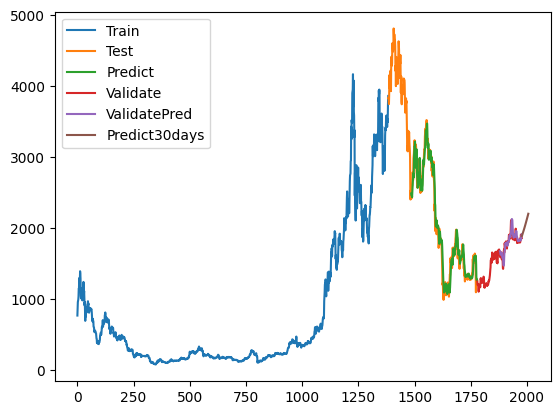

In [21]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(data1)-1, stop=len(data1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()